# $e/\gamma$ ECAL Shower Classification with ML

### Introduction

<figure style="float:left">
<img src="./images/cms_overall.png" alt="CMS Overview" width=400/>
    <figcaption style="float:right"><b>[1]</b> Overview of the CMS detector</figcaption>
</figure>

<figure style="float:right">
<img src="./images/cms_layout_transverse.png" alt="CMS Transverse Layout" width=550/>
    <figcaption style="float:right"><b>[2]</b> Transverse layout of the CMS detector</figcaption>
</figure>

The Large Hadron Collider (LHC) at CERN smashes protons together at close to the speed of light. Some of the collision energy is turned into mass, creating new particles which are observed in the Compact Muon Solenoid (CMS) particle detector **[1]**. Different layers of the CMS detector **[2]** measure different particles and phenomena produced in the high-energy collision, which are later analyzed to reconstruct a picture of events at the heart of the collision. Electromagnetic calorimeter (ECAL) at the CMS detector measures electrons ($e$) and photons ($\gamma$) from their energy deposits, called "shower", in the calorimeter. 

With the measurements from ECAL, combined with those from the previous layer of the detector, silicon tracker, physicists are able to identify and reconstruct the electrons and photons. However, with the information of ECAL shower only, it is not possible with the "traditional" method to identify the particle as electron or photon. 

In this project, we will classify the particle ($e$/$\gamma$) with Deep Learning method, from 2D image data of their shower in the ECAL. 

### Overview of ECAL

<figure style="float:right">
<img src="./images/ECAL_yz.png" alt="ECAL y-z Plane View" width=480/>
</figure>

<figure style="float:left">
<img src="./images/ECAL_overview.png" alt="ECAL Overview" width=420/>
</figure>

The CMS electromagnetic calorimeter (ECAL) is made up of 75,848 homogeneous lead tungstate ($PbWO_{4}$) crystals. When electrons and photons pass through the crystal, it "scintillates" and produces light in proportion to the particle's energy. The photodetectors, glued onto the back of each of the crystals, detect the scintillation light and convert it to an electrical signal that is amplified and sent for analysis. 

The crystals are arranged in a central barrel section with pseudorapidity coverage up to $\eta$ = 1.479, closed by two endcaps extending the coverage up to $\eta$ = 3.0. The cylindrical barrel consists of 61,200 crystals formed into 36 "supermodules", each containing 1700 crystals. For extra spatial precision, the ECAL also contains Preshower detectors that sit in front of the endcaps. These allow CMS to distinguish between single high-energy photons (often signs of exciting physics) and the less interesting close pairs of low-energy photons. 

In this project, we will use ECAL shower data from the barrel section only. 

### Now, let's work with data!

We will use detector simulation Monte-Carlo data, simulating the following processes below:
1. **Electrons** in the final state: *'DoubleElectronPt15To100_pythia8_PU2017_MINIAODSIM.**'* data
2. **Photons** in the final state: *'DoublePhotonPt15To100_pythia8_PU2017_MINIAODSIM.**'* data

In [32]:
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import glob

In [33]:
# Import data

# electron data
elec = glob.glob('./data/DoubleElectronPt15To100_pythia8_PU2017_MINIAODSIM.parquet.[1-8]')
elec = [pq.ParquetFile(i) for i in elec]

nEntries_elec = [f.num_row_groups for f in elec] # total event number in the electron data files

# photon data
pho = glob.glob('./data/DoublePhotonPt15To100_pythia8_PU2017_MINIAODSIM.parquet.[1-8]')
pho = [pq.ParquetFile(i) for i in pho]

nEntries_pho = [f.num_row_groups for f in pho] # total event number in the photon data files
    
#print(nEntries_elec, nEntries_pho)

#### Sneak peek into the physics variables in the data

In [34]:
pa_array = pq.read_table('./data/DoublePhotonPt15To100_pythia8_PU2017_MINIAODSIM.parquet.1')

print('Some of the e/gamma physics variables')
print("\n* Identification-related (a lot of jargons here, so don't worry if you don't understand things here)")
print('pho_id: r9 = {}, sieie = {}, phoIso = {}, chgIso = {}, chgIsoWrongVtx = {}, Eraw = {}, phiWidth = {}, etaWidth = {}, scEta = {}, sieip = {}, s4 = {}'.format(pa_array[2][n][0], pa_array[2][n][1], pa_array[2][n][2], pa_array[2][n][3], pa_array[2][n][4], pa_array[2][n][5], pa_array[2][n][6], pa_array[2][n][7], pa_array[2][n][8], pa_array[2][n][9], pa_array[2][n][10]))
print('\n* Reconstructed particle info')
print('pho_p4: E = {}, pT = {}, eta = {}, phi = {}'.format(pa_array[8][n][0], pa_array[8][n][1], pa_array[8][n][2], pa_array[8][n][3]))
print('\n* Generator-level particle info')
print('pi0_p4: E = {}, pT = {}, eta = {}, phi = {}'.format(pa_array[8][n][0], pa_array[8][n][1], pa_array[8][n][2], pa_array[3][n][3]))

Some of the e/gamma physics variables

* Identification-related (a lot of jargons here, so don't worry if you don't understand things here)
pho_id: r9 = 0.9429008960723877, sieie = 0.00928547140210867, phoIso = 1.18896484375, chgIso = 0.0, chgIsoWrongVtx = 6.415283203125, Eraw = 98.97994995117188, phiWidth = 0.053681448101997375, etaWidth = 0.011072281748056412, scEta = 0.8928331732749939, sieip = 6.220493105502101e-06, s4 = 0.9117343425750732

* Reconstructed particle info
pho_p4: E = 97.0477523803711, pT = 67.87133026123047, eta = 0.8968680500984192, phi = -0.7883466482162476

* Generator-level particle info
pi0_p4: E = 97.0477523803711, pT = 67.87133026123047, eta = 0.8968680500984192, phi = -0.788114070892334


### 2D ECAL Shower Image (32x32 window) for $e$ and $\gamma$

ECAL system uses its own coordinate (i$\eta$, i$\phi$), converted from the conventional $\eta$ (pseudorapidity) and $\phi$ (azimuthal angle in the transverse plane) coordinate of the CMS experiment. As dataset for classification, we will use 2D images of $e$/$\gamma$ shower in 32x32 window of the ECAL cluster in the (i$\eta$, i$\phi$) coordinate. Before we feed the data to the classifier, let's plot and look at the shower image for electron events and photon events, respectively. 

#### Plot 2D Image of Electron ECAL Shower for a ***Single Event***

<ipython-input-39-69f8fedd6e61>:17: RuntimeWarning: divide by zero encountered in log
  X_elec = np.log(X_elec)


Text(0.5, 1.0, 'Electron ECAL Crystal Energy Deposits (Event #: 32104)')

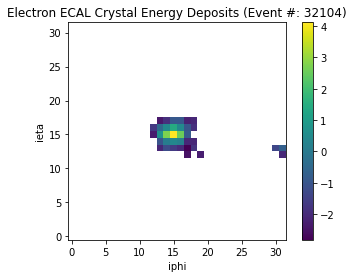

In [39]:
'''
Plot 2D ECAL shower image from ELECTRON data (SINGLE event)
'''

X_elec = [] # 32x32 image data

# Randomly pick a single event (event number n) from one of the data above
f = np.random.randint(0,len(elec))                # pick a file
n = np.random.randint(1, high=nEntries_elec[f])   # pick event number

# Get E/gamma shower image from the parquet table and convert it to 32x32 numpy array
X_elec = elec[f].read_row_group(n, 'X')
X_elec = X_elec.to_pydict()['X']
X_elec = np.array(X_elec).reshape(-1,32)

# Plot in log
X_elec = np.log(X_elec)

# Plot the shower image in 2d
img = plt.imshow(X_elec, interpolation='none', origin='lower')
bar = plt.colorbar(img)

plt.xlabel('iphi')
plt.ylabel('ieta')
plt.title('Electron ECAL Crystal Energy Deposits (Event #: {})'.format(n))

#plt.savefig("elec_images/Egamma_{}.png".format(n))

#### Plot 2D Image of Photon ECAL Shower for a ***Single Event***

<ipython-input-40-7e7d12720f76>:17: RuntimeWarning: divide by zero encountered in log
  X_pho = np.log(X_pho)


Text(0.5, 1.0, 'Photon ECAL Crystal Energy Deposits (Event #: 20758)')

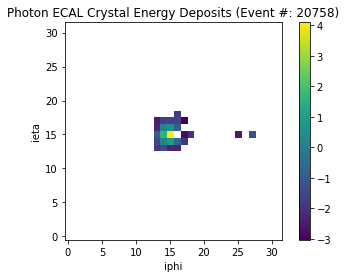

In [40]:
'''
Plot 2D ECAL shower image from PHOTON data (SINGLE event)
'''

X_pho = [] # 32x32 image data

# Randomly pick a single event (event number n) from one of the data above
f = np.random.randint(0,len(pho))                # pick a file
n = np.random.randint(1, high=nEntries_elec[f])  # pick event number

# Get E/gamma shower image from the parquet table and convert it to 32x32 numpy array
X_pho = pho[f].read_row_group(n, 'X')
X_pho = X_pho.to_pydict()['X']
X_pho = np.array(X_pho).reshape(-1,32)

# Plot in log
X_pho = np.log(X_pho)

# Plot the shower image in 2d
img = plt.imshow(X_pho, interpolation='none', origin='lower')
bar = plt.colorbar(img)

plt.xlabel('iphi')
plt.ylabel('ieta')
plt.title('Photon ECAL Crystal Energy Deposits (Event #: {})'.format(n))

#plt.savefig("gamma_images/Egamma_{}.png".format(n))

#### Plot 2D Image of Electron ECAL Shower for ***5k Events (Averaged)***

<ipython-input-37-c2ccd64b5024>:17: RuntimeWarning: divide by zero encountered in log
  shower = np.log(shower)


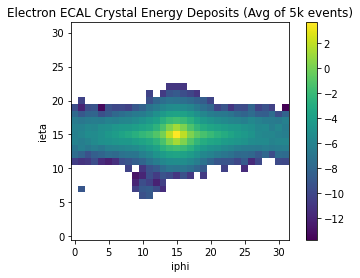

In [37]:
'''
Plot 2D ECAL shower image from ELECTRON data (Log Plot of 5k event AVG sum)
'''

shower = np.zeros([32,32])
for n in range(0,5000):
    # Get E/gamma shower image from the parquet table and convert it to 32x32 numpy array
    X = elec[0].read_row_group(n, 'X')
    X = X.to_pydict()['X']

    X = np.array(X).reshape(-1,32)

    shower += X

# Plot the image in 2d
shower /= 5000.
shower = np.log(shower)

img = plt.imshow(shower, interpolation='none', origin = 'lower')
bar = plt.colorbar(img)

plt.xlabel('iphi')
plt.ylabel('ieta')
plt.title('Electron ECAL Crystal Energy Deposits (Avg of 5k events)')
#plt.savefig("ee_EgammaAvg5k.png".format(n))

plt.show()

#### Plot 2D Image of Photon ECAL Shower for ***5k Events (Averaged)***

<ipython-input-38-7b1e3d7a9886>:17: RuntimeWarning: divide by zero encountered in log
  shower = np.log(shower)


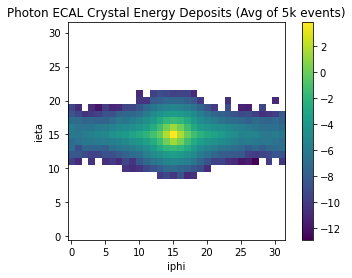

In [38]:
'''
Plot 2D ECAL shower image from PHOTON data (Log Plot of 5k event AVG sum)
'''

shower = np.zeros([32,32])
for n in range(0,5000):
    # Get E/gamma shower image from the parquet table and convert it to 32x32 numpy array
    X = pho[4].read_row_group(n, 'X')
    X = X.to_pydict()['X']

    X = np.array(X).reshape(-1,32)

    shower += X

# Plot the image in 2d
shower /= 5000.
shower = np.log(shower)

img = plt.imshow(shower, interpolation='none', origin = 'lower')
bar = plt.colorbar(img)

plt.xlabel('iphi')
plt.ylabel('ieta')
plt.title('Photon ECAL Crystal Energy Deposits (Avg of 5k events)')
#plt.savefig("gg_EgammaAvg5k.png".format(n))

plt.show()

*We will classify the particle as a photon or electron directly from its ECAL shower shape, using Deep Learning algorithm.*

## Deep Learning

<img src="./images/ann.png" alt="Neural Network structure" width=500/>

Deep learning, a subset of machine learning, attempts to learn from a training set the mapping of input data to output data, using neural network architecture. 
*Neural networks* are comprised of node layers: an input layer, one or more hidden layers, and an output layer. Each node connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network. 

The *training* of the neural network later facilitates the predictions made by it on a testing data of the same distribution. This mapping is attained by a set of trainable parameters called *weights*, distributed over different layers. The weights are learned by the *back propagation algorithm* whose aim is to minimize a *loss function*. A loss function measures how distant the predictions made by the network are from the actual values. 

Neural networks can be thought of as "universal function approximator".

### Convolutional Neural Network

<figure style="float:left">
<img src="./images/cnn.jpg" alt="CNN structure" width=600/>
    <figcaption style="float:right"><b>[1]</b> CNN Architecture</figcaption>
</figure>

<figure style="float:right">
<img src="./images/convolution.png" alt="Convolution operation" width=340/>
    <figcaption style="float:right"><b>[2]</b> Convolution Operation</figcaption>
</figure>

Neural networks can be classified into different types, which are used for different purposes. A Convolutional Neural Network (CNN) **[1]** is a Deep Learning algorithm which can take in input image and differentiate one from the other, successfully identifying patterns within an image. CNN architecture is comprised of the following main layers: convolutional layers, pooling layers, and fully connected layer. 

1. Convolutional layer "extracts" features of image, by performing convolution operation **[2]**: it computes the dot product between local regions in the input and the filter ("*kernel*"). Then it slides the kernel over the next local region repeating the same operation, until it goes through the whole image. It has ReLU activation function to make all negative value to zero. 

2. Pooling layer, used between convolutional layers, reduces the spatial volume of image after convolution, in order to avoid computationally expensive cost. 

3. Fully connected layer connects nodes in one layer to those in others to compute the "score" for each category and classify the images. 

In this way, CNN transforms the original image, layer by layer, from the original pixel values to the final class/category scores. 

### Residual Neural Network (ResNet)

<figure style="float:left">
    <img src="./images/nested.png" alt="Nested function classes" width=550/>
</figure>

<figure style="float:right">
<img src="./images/resnet.png" alt="Residual Blocks" width=350/>
    <figcaption style="float:right"><b>[1]</b> Residual Blocks</figcaption>
</figure>



While CNN performs a good fitting to image dataset with the reduction in the number of parameters involved and reusability of weights, the training becomes more difficult as more layers are added. It can have "*vanishing gradient problem*", which is an issue a typical neural network will have as you go "deeper". Moreover, adding layers to an existing network changes the structure of the network: the network is forced to use the new layer, altering the structure. That is, the "function class" gains complexity with more "depth" and does not overlap with the shallower network anymore. One way to solve this issue is to add layers in such a way that the network is free to ignore the new layers and can use the structures of the shallower network. 

This solution adds new layers, called *Residual Blocks* **[1]**, with a "skip" connection that allows gradients to flow directly through the network. With an identity mapping around, the new layers then get summed into the shallow network. By reducing complexity, the Residual Neural Network (ResNet) keeps less number of parameters to be trained and can solve the aforementioned issues with "going deep". 

### Let's start training!

In [25]:
import numpy as np
np.random.seed(0)
import os, glob
import time
import h5py
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch_resnet_single as networks
from torch.utils.data import ConcatDataset,DataLoader,sampler
from sklearn.metrics import roc_curve, auc
from utils import *
import argparse
from torchsummary import summary

#### Input data (Electron and Photon Data) and split them into training and validation set

In [31]:
# Input Data

event_data = glob.glob('./data/Double*Pt15To100_pythia8_PU2017_MINIAODSIM.parquet.[1-8]')
#event_data = glob.glob('./data/DoubleElectronPt15To100_pythia8_PU2017_MINIAODSIM.parquet.[1-8]')
#event_data += glob.glob('./data/DoublePhotonPt15To100_pythia8_PU2017_MINIAODSIM.parquet.[1-6]')

print(">> Input files:", [ s[13:17]+'.'+s[-1] for s in event_data ])

assert len(event_data) >= 2, "Must have at least 1 photon + 1 electron file."

>> Input files: ['Phot.4', 'Phot.3', 'Phot.2', 'Phot.5', 'Elec.4', 'Elec.3', 'Elec.2', 'Elec.5', 'Phot.7', 'Phot.6', 'Phot.1', 'Phot.8', 'Elec.7', 'Elec.6', 'Elec.1', 'Elec.8']


In [4]:
# Training dataset - for optimizing net
train_set = ConcatDataset([ParquetDatasetLimited(d) for d in event_data])
idxs = np.random.permutation(len(train_set))
train_cut = int(0.7*len(train_set)) # training set size, remainder used for validation

train_sampler = sampler.SubsetRandomSampler(idxs[:train_cut])
train_loader = DataLoader(dataset=train_set, batch_size=32, num_workers=4, sampler=train_sampler, pin_memory=True)        

In [5]:
# Validation dataset - for evaluating net performance
val_set = ConcatDataset([ParquetDatasetLimited(d) for d in event_data])
val_sampler = sampler.SubsetRandomSampler(idxs[train_cut:])
val_loader = DataLoader(dataset=val_set, batch_size=120, num_workers=4, sampler=val_sampler)

#### Create neural network with Resnet architecture

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = out_channels//in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        #self.relu = nn.ReLU(inplace=True)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample > 1:
            residual = self.shortcut(x)

        out += residual
        out = self.relu(out)

        return out

In [8]:
class ResNet(nn.Module):

    def __init__(self, in_channels, nblocks, fmaps):
        super(ResNet, self).__init__()
        self.fmaps = fmaps
        self.nblocks = nblocks

        self.conv0 = nn.Conv2d(in_channels, fmaps[0], kernel_size=7, stride=1, padding=1)
        self.layer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]])
        self.layer2 = self.block_layers(1, [fmaps[0],fmaps[1]])
        self.layer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]])
        self.fc = nn.Linear(fmaps[1], 1)
        
    def block_layers(self, nblocks, fmaps):
        layers = []
        for _ in range(nblocks):
            layers.append(ResBlock(fmaps[0], fmaps[1]))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv0(x)
        x = F.leaky_relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = x.view(x.size()[0], self.fmaps[1])
        x = self.fc(x)
        #x = self.FCN(x)
        
        return x

#### Set training parameters and create model

In [9]:
# Training parameters
lr_init = 1.5e-4
resblocks = 3
epochs = 20

In [10]:
# Create model with torch_resnet_single structure
resnet = ResNet(1, resblocks, [16, 32])

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
resnet.cuda()

optimizer = optim.Adam(resnet.parameters(), lr=lr_init)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.5)

#### Model Summary

In [28]:
# See summary of the net
print(resnet)

ResNet(
  (conv0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Conv2d

In [30]:
# See summary of the net (cont'd) with output shape after each layer and the number of parameters
summary(resnet, (1,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 28, 28]          800
├─Sequential: 1-2                        [-1, 16, 14, 14]          --
|    └─ResBlock: 2-1                     [-1, 16, 14, 14]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 14, 14]          2,320
|    |    └─LeakyReLU: 3-2               [-1, 16, 14, 14]          --
|    |    └─Conv2d: 3-3                  [-1, 16, 14, 14]          2,320
|    |    └─LeakyReLU: 3-4               [-1, 16, 14, 14]          --
|    └─ResBlock: 2-2                     [-1, 16, 14, 14]          --
|    |    └─Conv2d: 3-5                  [-1, 16, 14, 14]          2,320
|    |    └─LeakyReLU: 3-6               [-1, 16, 14, 14]          --
|    |    └─Conv2d: 3-7                  [-1, 16, 14, 14]          2,320
|    |    └─LeakyReLU: 3-8               [-1, 16, 14, 14]          --
|    └─ResBlock: 2-3                     [-1, 16, 14, 14]          --
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 28, 28]          800
├─Sequential: 1-2                        [-1, 16, 14, 14]          --
|    └─ResBlock: 2-1                     [-1, 16, 14, 14]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 14, 14]          2,320
|    |    └─LeakyReLU: 3-2               [-1, 16, 14, 14]          --
|    |    └─Conv2d: 3-3                  [-1, 16, 14, 14]          2,320
|    |    └─LeakyReLU: 3-4               [-1, 16, 14, 14]          --
|    └─ResBlock: 2-2                     [-1, 16, 14, 14]          --
|    |    └─Conv2d: 3-5                  [-1, 16, 14, 14]          2,320
|    |    └─LeakyReLU: 3-6               [-1, 16, 14, 14]          --
|    |    └─Conv2d: 3-7                  [-1, 16, 14, 14]          2,320
|    |    └─LeakyReLU: 3-8               [-1, 16, 14, 14]          --
|    └─ResBlock: 2-3                     [-1, 16, 14, 14]          --
| 

#### Validation function

In [54]:
# Function to validate after training phase
val_loss, val_acc = [], []

def do_eval(resnet, val_loader, roc_auc_best, epoch):
    loss_, acc_ = 0., 0.
    y_pred_, y_truth_, pt_ = [], [], []
    now = time.time()
    for i, data in enumerate(val_loader):
        X, y, pt = data['X'].cuda(), data['m'].cuda(), data['pt'].cuda() # electron/photon id stored in 'm' key
        logits = resnet(X)
        y = y.type_as(logits) # needs to be same type as logits for next line
        loss_ += F.binary_cross_entropy_with_logits(logits, y).item()
        pred = logits.ge(0.).byte()
        acc_ += pred.eq(y.byte()).float().mean().item()
        y_pred = torch.sigmoid(logits) # for now, maybe relu?
        # Store batch metrics:
        y_pred_.append(y_pred.tolist())
        y_truth_.append(y.tolist())
        pt_.append(pt.tolist())

    now = time.time() - now
    y_pred_ = np.concatenate(y_pred_)
    y_truth_ = np.concatenate(y_truth_)
    pt_ = np.concatenate(pt_)
    s = '\n%d: Val time:%.2fs in %d steps'%(epoch, now, len(val_loader))
    print(s)
    s = '%d: Val loss:%.4f, acc:%.4f'%(epoch, loss_/len(val_loader), acc_/len(val_loader))
    print(s)

    val_loss.append(loss_/len(val_loader))
    val_acc.append(acc_/len(val_loader))
    print('Epoch: {}, Validation loss: {:.4f}, Validation accuracy: {:.4f}'.format(epoch, val_loss[epoch-1], val_acc[epoch-1]))
    
    fpr, tpr, _ = roc_curve(y_truth_, y_pred_)
    roc_auc = auc(fpr, tpr)
    s = "VAL ROC AUC: %.4f"%(roc_auc)
    print(s)

    if roc_auc > roc_auc_best:
        roc_auc_best = roc_auc
    
    return roc_auc_best

#### Run training and validation

In [55]:
# MAIN #
print_step = 1000
roc_auc_best = 0.5
print(">> Training <<<<<<<<")

# training loss and accuracy
train_loss, train_acc = [], []

# training loop
for e in range(epochs):

    epoch = e+1
    s = '\n>> Epoch %d <<<<<<<<'%(epoch)
    print(s)
    
    # Run training
    resnet.train()
    now = time.time()
    running_loss, running_acc = 0, 0
    
    for i, data in enumerate(train_loader):
        X, y = data['X'].cuda(), data['m'].cuda()
        optimizer.zero_grad()
        logits = resnet(X)
        y = y.type_as(logits) #same type for next line
        loss = F.binary_cross_entropy_with_logits(logits, y).cuda()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        pred = logits.ge(0.).byte()
        acc = pred.eq(y.byte()).float().mean()
        running_acc += acc.item()

        if i % print_step == 0:
            pred = logits.ge(0.).byte()
            acc = pred.eq(y.byte()).float().mean()
            s = '%d: Train loss:%.4f, acc:%.4f'%(epoch, loss.item(), acc.item())
            print(s)
            
    now = time.time() - now
    s = '%d: Train time:%.2fs in %d steps'%(epoch, now, len(train_loader))
    print(s)

    train_loss.append(running_loss/len(train_loader))
    train_acc.append(running_acc/len(train_loader))
    print('Epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}'.format(epoch, train_loss[epoch-1], train_acc[epoch-1]))

    # Run Validation
    resnet.eval()
    roc_auc_best = do_eval(resnet, val_loader, roc_auc_best, epoch)
    lr_scheduler.step()

>> Training <<<<<<<<

>> Epoch 1 <<<<<<<<
1: Train loss:0.8422, acc:0.3750
1: Train loss:0.6637, acc:0.5625
1: Train loss:0.6516, acc:0.6875
1: Train loss:0.5440, acc:0.8125
1: Train loss:0.5008, acc:0.6875
1: Train loss:0.5397, acc:0.7500
1: Train loss:0.5277, acc:0.7500
1: Train loss:0.6292, acc:0.6875
1: Train loss:0.6285, acc:0.5938
1: Train loss:0.4864, acc:0.8125
1: Train loss:0.4269, acc:0.8750
1: Train loss:0.5722, acc:0.7188
1: Train loss:0.4546, acc:0.8125
1: Train loss:0.6122, acc:0.6875
1: Train loss:0.4376, acc:0.7500
1: Train loss:0.5134, acc:0.7812
1: Train loss:0.5965, acc:0.6875
1: Train loss:0.5051, acc:0.6875
1: Train loss:0.5611, acc:0.7812
1: Train loss:0.5615, acc:0.6562
1: Train loss:0.5927, acc:0.7500
1: Train loss:0.5252, acc:0.7812
1: Train time:445.20s in 21216 steps
Epoch: 1, Train loss: 0.5820, Train accuracy: 0.6872

1: Val time:59.70s in 2425 steps
1: Val loss:0.5709, acc:0.6968
Epoch: 1, Validation loss: 0.5709, Validation accuracy: 0.6968
VAL ROC AUC: 0

9: Train loss:0.5133, acc:0.7188
9: Train loss:0.4497, acc:0.7500
9: Train loss:0.6616, acc:0.6562
9: Train loss:0.5807, acc:0.5938
9: Train loss:0.5731, acc:0.6562
9: Train loss:0.4647, acc:0.8125
9: Train loss:0.5703, acc:0.7188
9: Train loss:0.4950, acc:0.7500
9: Train loss:0.4545, acc:0.7500
9: Train loss:0.4331, acc:0.8125
9: Train loss:0.5257, acc:0.7500
9: Train loss:0.5114, acc:0.8438
9: Train loss:0.5850, acc:0.7188
9: Train time:190.05s in 21216 steps
Epoch: 9, Train loss: 0.5327, Train accuracy: 0.7291

9: Val time:57.96s in 2425 steps
9: Val loss:0.5352, acc:0.7261
Epoch: 9, Validation loss: 0.5352, Validation accuracy: 0.7261
VAL ROC AUC: 0.7838

>> Epoch 10 <<<<<<<<
10: Train loss:0.5393, acc:0.7812
10: Train loss:0.6173, acc:0.6250
10: Train loss:0.3469, acc:0.8438
10: Train loss:0.7802, acc:0.4375
10: Train loss:0.5211, acc:0.7188
10: Train loss:0.5455, acc:0.7812
10: Train loss:0.5186, acc:0.6562
10: Train loss:0.4532, acc:0.6875
10: Train loss:0.5004, acc:0.7500
10: T

17: Train loss:0.5819, acc:0.7500
17: Train loss:0.4566, acc:0.7188
17: Train loss:0.5111, acc:0.7812
17: Train loss:0.4060, acc:0.9062
17: Train loss:0.6460, acc:0.5938
17: Train loss:0.6819, acc:0.6562
17: Train loss:0.6159, acc:0.6250
17: Train loss:0.4090, acc:0.8125
17: Train loss:0.5284, acc:0.8125
17: Train time:190.58s in 21216 steps
Epoch: 17, Train loss: 0.5194, Train accuracy: 0.7403

17: Val time:58.05s in 2425 steps
17: Val loss:0.5285, acc:0.7320
Epoch: 17, Validation loss: 0.5285, Validation accuracy: 0.7320
VAL ROC AUC: 0.7895

>> Epoch 18 <<<<<<<<
18: Train loss:0.4556, acc:0.8438
18: Train loss:0.4864, acc:0.7812
18: Train loss:0.4057, acc:0.8125
18: Train loss:0.8236, acc:0.5312
18: Train loss:0.3665, acc:0.8750
18: Train loss:0.4729, acc:0.7188
18: Train loss:0.4276, acc:0.8125
18: Train loss:0.5646, acc:0.7188
18: Train loss:0.4433, acc:0.8438
18: Train loss:0.5301, acc:0.6562
18: Train loss:0.5445, acc:0.7812
18: Train loss:0.5481, acc:0.7500
18: Train loss:0.5913

ROC AUC: 0.7905


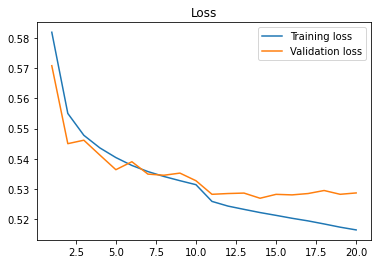

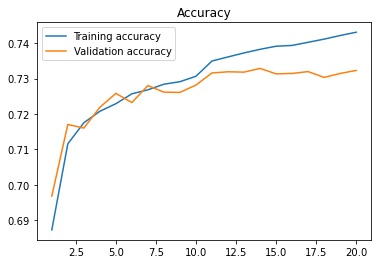

In [95]:
print("ROC AUC: {:.4f}".format(roc_auc_best))

# Plot loss and accuracy curve
plt.plot(list(range(1,epoch+1)), train_loss, label='Training loss')
plt.plot(list(range(1,epoch+1)), val_loss, label='Validation loss')
plt.legend()
plt.title("Loss")
#plt.savefig('loss.png')
plt.show()

plt.plot(list(range(1,epoch+1)), train_acc, label='Training accuracy')
plt.plot(list(range(1,epoch+1)), val_acc, label='Validation accuracy')
plt.legend()
plt.title("Accuracy")
#plt.savefig('accuracy.png')
plt.show()

### Takeaways

With Residual Neural Network, we classified $e$/$\gamma$ from ECAL shower image data. 

You can further try the following with this notebook:
* Take a closer look at the data: plot other physics variables inside the data other than the shower image.
* Play with the parameters for training and check the performance: change initial learning rate, number of epochs, batch size, activation function, number of residual blocks, etc.
* Try different architecture of neural network.